In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from agents import FrustratedRescorlaAgent
from gym import SimpleBanditTask


In [2]:
def run_simulation(N, trials_per_block, alpha, beta, v0):
    # environment
    env = SimpleBanditTask(N_TRIALS = N, BLOCK_LEN=trials_per_block, BLOCK_TRANSITION_LEN=5)
    
    # agent
    agent = FrustratedRescorlaAgent()
    agent.ALPHA = alpha
    agent.BETA = beta
    agent.V_SHIFT = v0
    
    # simulate trials
    reward = 0
    for i in range(N):
        action = agent.act(reward)
        reward = env.step(action)

    # extract info (session data)
    session_data = env.extract_info()

    return session_data

# Simulation

This one simulates data with many parameters and saves it to the data folder.

In [3]:
### simulation params
N = 80000  # number of trials
trials_per_block = 40  # number of trials per block

### model params
alphas = np.arange(0, 1.1, .2) 
# log scale from 5 to 100, 5 values
betas = np.logspace(np.log10(5), np.log10(30), 5)
v0s = np.arange(0, .55, .1)

In [4]:
path = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/data/simulated/behavior'

'''path = 'C:\\ZSOMBI\\OneDrive\\PoPy\\data\\simulated\\behavior'

for a, alpha in enumerate(alphas):
    for b, beta in enumerate(betas):
        for v, v0 in enumerate(v0s):
            session_data = run_simulation(N, trials_per_block, alpha, beta, v0)

            # save data as pickle
            session_data.to_pickle(path + f'\simulated_data_a{a}_b{b}_v{v}.pkl')'''

"path = 'C:\\ZSOMBI\\OneDrive\\PoPy\\data\\simulated\\behavior'\n\nfor a, alpha in enumerate(alphas):\n    for b, beta in enumerate(betas):\n        for v, v0 in enumerate(v0s):\n            session_data = run_simulation(N, trials_per_block, alpha, beta, v0)\n\n            # save data as pickle\n            session_data.to_pickle(path + f'\\simulated_data_a{a}_b{b}_v{v}.pkl')"

# Load simulated data and analyse (todo - to new file...)

In [5]:
n_blocks = N // trials_per_block  # number of blocks

res_best = np.empty((len(alphas), len(betas), len(v0s), n_blocks, trials_per_block))
res_shift = np.empty((len(alphas), len(betas), len(v0s), n_blocks, trials_per_block))
efficiency = np.empty((len(alphas), len(betas), len(v0s)))

for a, alpha in enumerate(alphas):
    for b, beta in enumerate(betas):
        for v, v0 in enumerate(v0s):
            fname = os.path.join(path, f'simulated_data_a{a}_b{b}_v{v}.pkl')
            session_data = pd.read_pickle(fname)
            
            # proportion of correct choices
            session_data['correct'] = session_data['target'] == session_data['best_target']
            session_data['shift'] = session_data['target'] != session_data['target'].shift(1)

            # make dataset: n_blocks X n_trials_per_block, containing correct choices
            best_sel_dataset = session_data.pivot(index='block_id', columns='trial_in_block', values='correct').values
            shift_dataset = session_data.pivot(index='block_id', columns='trial_in_block', values='shift').values

            res_best[a, b, v] = best_sel_dataset
            res_shift[a, b, v] = shift_dataset
            efficiency[a, b, v] = session_data.feedback.mean()

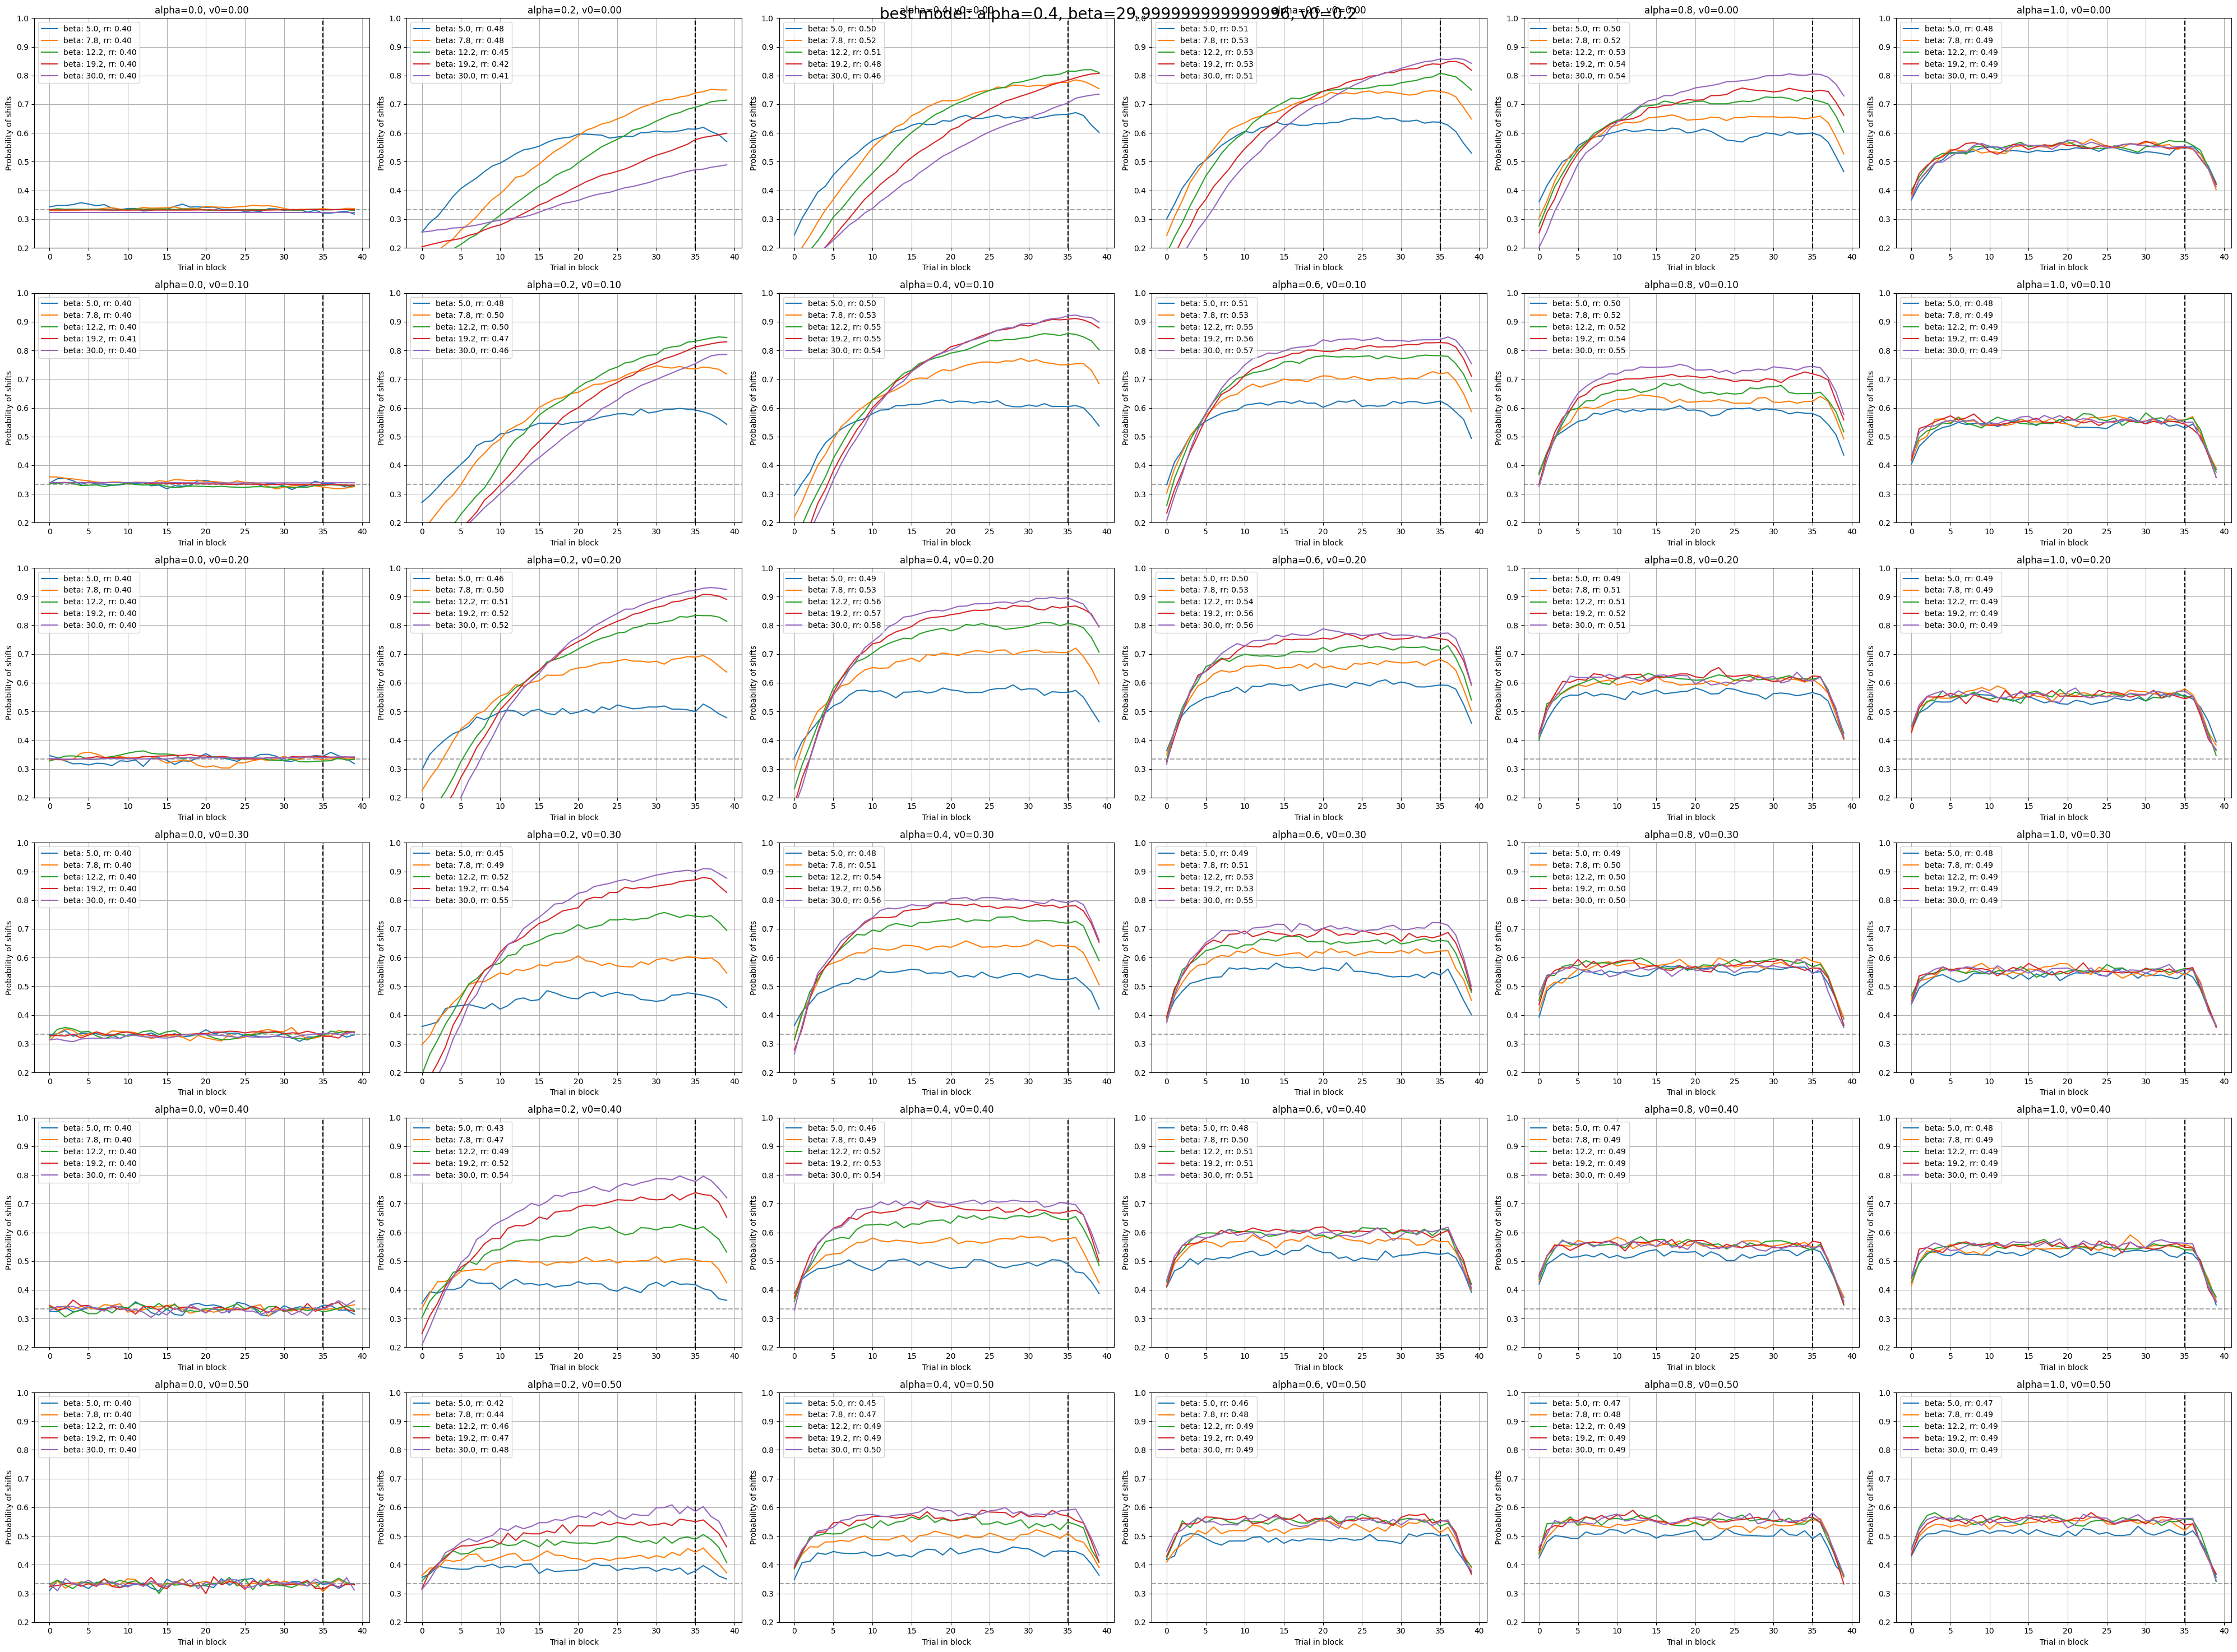

In [6]:
fig, axs = plt.subplots(len(v0s), len(alphas), figsize=(40, 30))

# max id in efficiency matrix (with all coordinates)
max_id = np.unravel_index(np.argmax(efficiency), efficiency.shape)
# set title
title = 'best model: alpha={}, beta={}, v0={}'.format(alphas[max_id[0]], betas[max_id[1]], v0s[max_id[2]])
fig.suptitle(title, fontsize=20)

for a, alpha in enumerate(alphas):
    for v, v0 in enumerate(v0s):
        ax = axs[v, a]
        ax.set_title(f'alpha={alpha:.1f}, v0={v0:.2f}')
        ax.set_ylim(0.2, 1)
        ax.axvline(35, color='k', linestyle='--')
        ax.axhline(1/3, color='grey', linestyle='--', alpha=.7)

        # legend next to plot
        ax.set_xlabel('Trial in block')
        #ax.set_ylabel('Proportion of correct choices')
        ax.set_ylabel('Probability of shifts')
        ax.grid()

        for b, beta in enumerate(betas):
            data = res_best[a, b, v]
            eff = efficiency[a, b, v]

            #for a, alpha in enumerate(alphas):
            ax.plot(data.mean(axis=0), label=f'beta: {beta:.1f}, rr: {eff:.2f}')
        
        ax.legend()
        
fig.tight_layout()

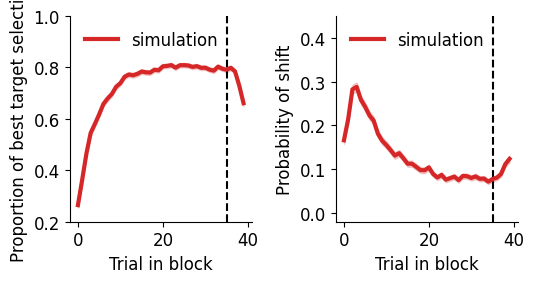

In [22]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(1, 2, figsize=(5.5, 3))
# fontsize
plt.rcParams.update({'font.size': 12})
colors = {'ka': 'tab:red', 'po': 'tab:orange'}

a, v, b = 2, 3, -1

ax = axs[0]
ax.axvline(35, color='k', linestyle='--')

# legend next to plot
ax.set_xlabel('Trial in block')
#ax.set_ylabel('Proportion of correct choices')
ax.set_ylabel('Probability of shifts')

data = res_best[a, b, v]
eff = efficiency[a, b, v]

#for a, alpha in enumerate(alphas):
ax.plot(data.mean(axis=0), color='tab:red', linewidth=3, label='simulation')
# plot standard error 
se = data.std(axis=0) / np.sqrt(data.shape[0])
ax.fill_between(np.arange(data.shape[1]), data.mean(axis=0) - se, data.mean(axis=0) + se, alpha=.2, color='tab:red')

a, v, b = 2, 2, -1

ax = axs[1]
ax.axvline(35, color='k', linestyle='--')

# legend next to plot
ax.set_xlabel('Trial in block')
#ax.set_ylabel('Proportion of correct choices')
ax.set_ylabel('Probability of shifts')

data = res_shift[a, b, v]
eff = efficiency[a, b, v]

#for a, alpha in enumerate(alphas):
ax.plot(data.mean(axis=0), color='tab:red', linewidth=3, label='simulation')
# plot standard error 
se = data.std(axis=0) / np.sqrt(data.shape[0])
ax.fill_between(np.arange(data.shape[1]), data.mean(axis=0) - se, data.mean(axis=0) + se, alpha=.2, color='tab:red')

# plot settings
ax = axs[0]
#ax.set_title('Best target selection')
ax.set_xlabel('Trial in block')
ax.set_ylabel('Proportion of best target selection')
ax.set_ylim([0.2, 1])
# set ticks every .2
ax.set_yticks(np.arange(0.2, 1.1, 0.2))
ax.legend(loc='upper left', frameon=False)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#fig.savefig(f'C:\\ZSOMBI\\OneDrive\\PoPy\\figs\\neurofrance\\best_targett.svg', format='svg') 

ax = axs[1]
#ax.set_title('Shift')
ax.set_xlabel('Trial in block', fontsize=12)
ax.set_ylabel('Probability of shift', fontsize=12)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim([-0.02, .45])
ax.legend(loc='upper left', frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
# save figure, full
outpath = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/sim_behav.svg'
fig.savefig(outpath, format='svg', dpi=300, bbox_inches='tight')

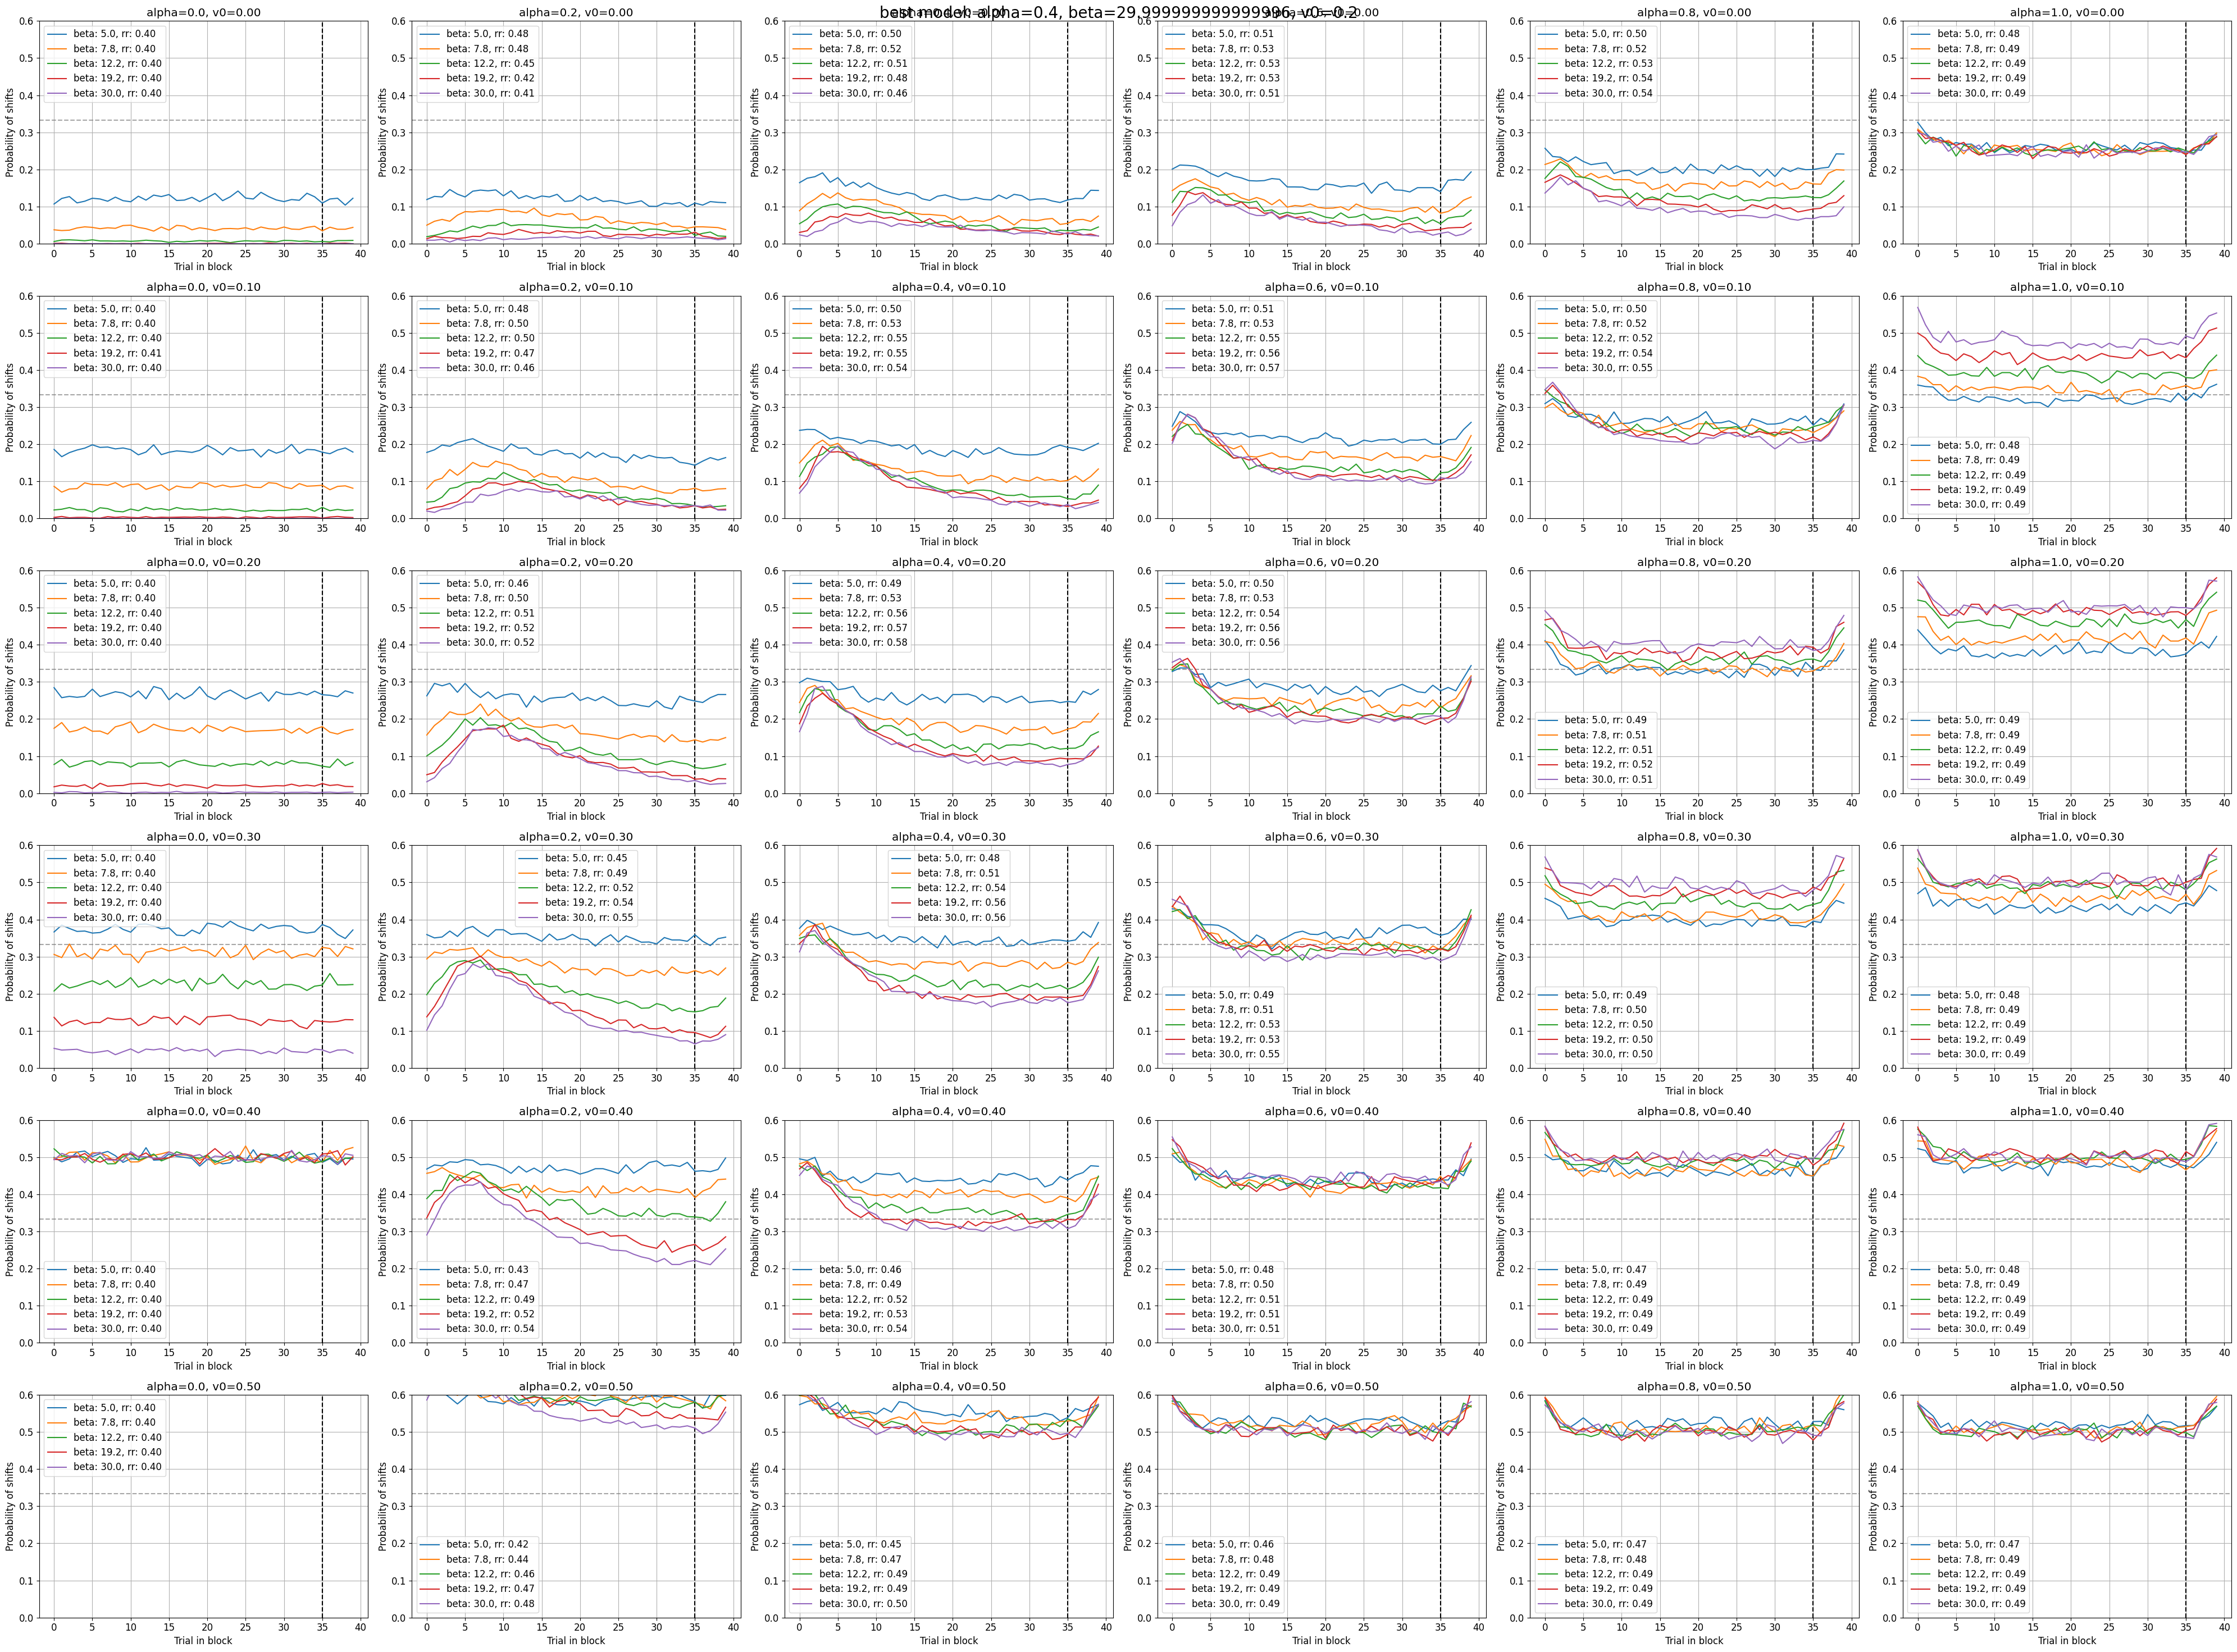

In [8]:
fig, axs = plt.subplots(len(v0s), len(alphas), figsize=(40, 30))

# max id in efficiency matrix (with all coordinates)
max_id = np.unravel_index(np.argmax(efficiency), efficiency.shape)
# set title
title = 'best model: alpha={}, beta={}, v0={}'.format(alphas[max_id[0]], betas[max_id[1]], v0s[max_id[2]])
fig.suptitle(title, fontsize=20)

for a, alpha in enumerate(alphas):
    for v, v0 in enumerate(v0s):
        ax = axs[v, a]
        ax.set_title(f'alpha={alpha:.1f}, v0={v0:.2f}')
        ax.set_ylim(0, .6)
        ax.axvline(35, color='k', linestyle='--')
        ax.axhline(1/3, color='grey', linestyle='--', alpha=.7)

        # legend next to plot
        ax.set_xlabel('Trial in block')
        #ax.set_ylabel('Proportion of correct choices')
        ax.set_ylabel('Probability of shifts')
        ax.grid()

        for b, beta in enumerate(betas):
            data = res_shift[a, b, v]
            eff = efficiency[a, b, v]

            #for a, alpha in enumerate(alphas):
            ax.plot(data.mean(axis=0), label=f'beta: {beta:.1f}, rr: {eff:.2f}')
        
        ax.legend()
        
fig.tight_layout()